In [2]:
from __future__ import print_function
import pandapower as pp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import stable_baselines
import pickle
from stable_baselines import DDPG
from scipy.stats import wilcoxon
import sys
import copy
sys.path.append('C:\\Users\\vegar\\Dropbox\\Master\\thesis.git')
from  gym_power.envs.active_network_env import ActiveEnv
import seaborn as sns
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib notebook


# I need to see the actions of the agent
The agent activates flexibility to help the net. Need to plot the actions of the agent togeather with solar irradiance and demand at each load.


In [3]:
def stack_columns(df,columns):
    stacked = pd.DataFrame()
    values, labels = [], []
    for col in columns:
        values += list(df[col])
        labels += [col for _ in range(len(df))]
    stacked['Reward'] = values
    stacked[''] = labels
    return stacked
    

In [4]:
def pickle_savefig(fig,figname):
    matplotlib_name = 'figs/' + figname + '_plt.p'
    with open(matplotlib_name,'wb') as f:
        pickle.dump(fig,f)
    fig.savefig('figs/' + figname +'.png')
    
    
    
    

In [5]:
def read_pickle_fig(figname):
    with open('figs/'+figname +'_plt.p', 'rb') as f:
        fig = pickle.load(f)
    return fig

In [6]:
def find_load_names(sol_bus):
    nr_sol = 1
    nr_else = 1
    load_names = []
    for k in range(len(sol_bus)):
        if sol_bus[k]:
            load_names.append('sun {}'.format(nr_sol))
            nr_sol += 1
        else:
            load_names.append('load {}'.format(nr_else))
            nr_else += 1
    return load_names

In [7]:
def simulate_day2(env,model, show_imbalance=False, show_solar=True, show_action=True,
                  show_demand=False,period=25):
    net = env.powergrid
    sol_bus = net.load['bus'].isin(net.sgen['bus'])
    actions = []
    t_steps = []
    flex_loads = []
    sols = []
    obs = env.reset()
    sol = env.solar_forecasts
    demand = env.demand_forecasts[0]
    names = find_load_names(sol_bus)
    hues = []
    for t_step in range(1,period):
        
        action,_ = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        
        if show_action:
            actions += list(action)
            hues += ['action' for _ in range(len(action))]
            t_steps += list(t_step*np.ones_like(action))
            flex_loads += names
        
        if show_solar:
            actions += list(sol[t_step-1]*np.ones_like(action))
            hues += ['sun' for _ in range(len(action))]
            t_steps += list(t_step*np.ones_like(action))
            flex_loads += names
        if show_imbalance:
            try:
                imbalance = env.calc_balance()/30000
            except AttributeError:
                imbalance = env.calc_imbalance()/30000
            actions += list(imbalance*np.ones_like(action))
            hues += ['imbalance' for _ in range(len(action))]
            t_steps += list(t_step*np.ones_like(action))
            flex_loads += names
            
        if show_demand:
            actions += list(demand[t_step-1]*np.ones_like(action))
            hues += ['demand' for _ in range(len(action))]
            t_steps += list(t_step*np.ones_like(action))
            flex_loads += names
            


    df = pd.DataFrame()
    df['actions'] = actions
    df['steps'] = t_steps
    df['load'] = flex_loads
    df[''] = hues
    return df

In [8]:
def data_from_subplot(ax, imbalance=False):
    actions = ax.lines[3].get_ydata()
    sun = ax.lines[4].get_ydata()
    balance = ax.lines[5].get_ydata()
    oneplot = pd.DataFrame()
    if imbalance:
        oneplot['Energy imbalance'] = balance
    oneplot['Solar irradiance'] = sun
    oneplot['Action'] = actions
    return oneplot

In [9]:
def change_hours(x,start=155):
    return x-start
def change_legend(x):
    if x == 'No agent':
        return 'No action'
    else:
        return x

## Import models

In [10]:
def load_env(model_name='flexible_load_first',seed=9):
#flexible_load_first, overnight, larger_margin_cost, discount_06, flex50

    params_name = model_name +'_params.p'
    model = DDPG.load('models/'+model_name)
    env = ActiveEnv(seed=seed)
    with open('models/' + params_name,'rb') as f:
        params = pickle.load(f)

    env.set_parameters(params)
    model.set_env(env)
    return model, env

In [12]:
model, env = load_env()

Loading a model without an environment, this model cannot be trained until it has a valid environment.
setting up target updates ...
  target/pi/fc0/kernel:0 <- model/pi/fc0/kernel:0
  target/pi/fc0/bias:0 <- model/pi/fc0/bias:0
  target/pi/LayerNorm/beta:0 <- model/pi/LayerNorm/beta:0
  target/pi/LayerNorm/gamma:0 <- model/pi/LayerNorm/gamma:0
  target/pi/fc1/kernel:0 <- model/pi/fc1/kernel:0
  target/pi/fc1/bias:0 <- model/pi/fc1/bias:0
  target/pi/LayerNorm_1/beta:0 <- model/pi/LayerNorm_1/beta:0
  target/pi/LayerNorm_1/gamma:0 <- model/pi/LayerNorm_1/gamma:0
  target/pi/pi/kernel:0 <- model/pi/pi/kernel:0
  target/pi/pi/bias:0 <- model/pi/pi/bias:0
  target/qf/fc0/kernel:0 <- model/qf/fc0/kernel:0
  target/qf/fc0/bias:0 <- model/qf/fc0/bias:0
  target/qf/LayerNorm/beta:0 <- model/qf/LayerNorm/beta:0
  target/qf/LayerNorm/gamma:0 <- model/qf/LayerNorm/gamma:0
  target/qf/fc1/kernel:0 <- model/qf/fc1/kernel:0
  target/qf/fc1/bias:0 <- model/qf/fc1/bias:0
  target/qf/LayerNorm_1/beta:

<IPython.core.display.Javascript object>


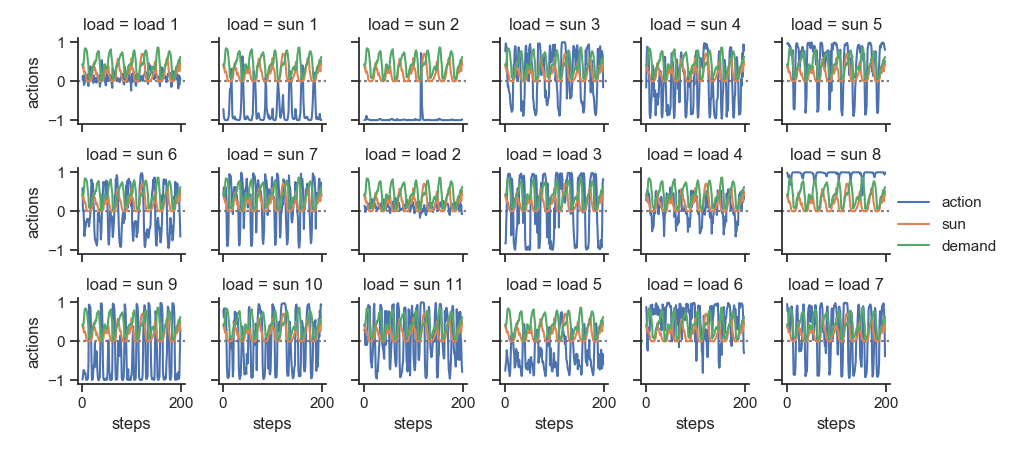

In [132]:
df = simulate_day2(env,model, show_demand=True, period=199)
sns.set(style="ticks")

grid = sns.FacetGrid(df, col="load", hue="",
                     col_wrap=6, height=1.5)

grid.map(plt.axhline, y=0, ls=":", c=".5")

grid.map(plt.plot, "steps", "actions")
grid.add_legend()



In [133]:
@interact
def plot_load(ax_nr1=range(18),ax_nr2=range(18),period=(0,200)):
    plot1 = data_from_subplot(grid.axes[ax_nr1],imbalance=True)
    plot2 = data_from_subplot(grid.axes[ax_nr2],imbalance=True)

    fig, axes = plt.subplots(2)
    #axes.set_title(ax.get_title())
    #axes.set_title('Total energy imbalance')
    axes[0].set_xlabel('steps')
    axes[0].axhline(0,c=".5",ls='--')
    axes[1].axhline(0,c=".5",ls='--')
    #axes.set_ylabel('MWh')
    plot1[:period].plot(ax=axes[0])
    plot2[:period].plot(ax=axes[1])
    plt.tight_layout()


interactive(children=(Dropdown(description='ax_nr1', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14…

## See resulting voltages etc

In [42]:
env.powergrid.res_bus

,vm_pu,va_degree,p_kw,q_kvar
0,1.030000,0.000000,-29900.456517,-9086.961999
1,1.009357,-3.664185,11333.733241,2933.480999
2,0.996422,-4.237402,0.000000,0.000000
3,0.975807,-5.144488,330.646468,144.530961
4,0.974814,-5.196491,322.639727,68.400152
5,0.974195,-5.227244,361.806933,115.281155
6,0.973481,-5.262905,262.167977,86.845137
7,0.972465,-5.277896,63.411203,34.208192
8,0.972660,-5.268847,385.352659,92.993465
9,0.972120,-5.286005,311.028317,256.561444


## Max/Min activation in all hours
See effect of letting the agent controll reactive power aswell

In [175]:
period=199
#model, env = load_env(seed=9)
env1 = ActiveEnv(seed=9)
net = env1.powergrid
actions = []
t_steps = []
flex_loads = []
obs = env1.reset()
sol = env1.solar_forecasts
hues = []
env1.set_parameters({'flexibility':0.25,
                   'solar_scale':1.2,
                   'reactive_power':False})
env2 = copy.deepcopy(env1)
env2.set_parameters({'reactive_power':True})
env2.solar_forecasts = env1.solar_forecasts 
env2.demand_forecasts = env1.demand_forecasts
env3 = copy.deepcopy(env1)
env3.do_action = False
legend_map = {0:'Active',1:'- 25 % demand', 2: 'No action'}


action = -np.ones(18)
for t_step in range(1,period):
    for i, env in enumerate([env1, env2, env3]):
        obs, rewards, dones, info = env.step(action)
        voltage = env.powergrid.res_bus.vm_pu
        actions += list(voltage)
        hues += [legend_map[i] for _ in range(len(voltage))]
        t_steps += list(t_step*np.ones_like(v_active))
        flex_loads += list(range(len(v_active)))

df = pd.DataFrame()
df['Voltage [pu]'] = actions
df['Hour'] = t_steps
df['Load'] = flex_loads
df[''] = hues

<IPython.core.display.Javascript object>


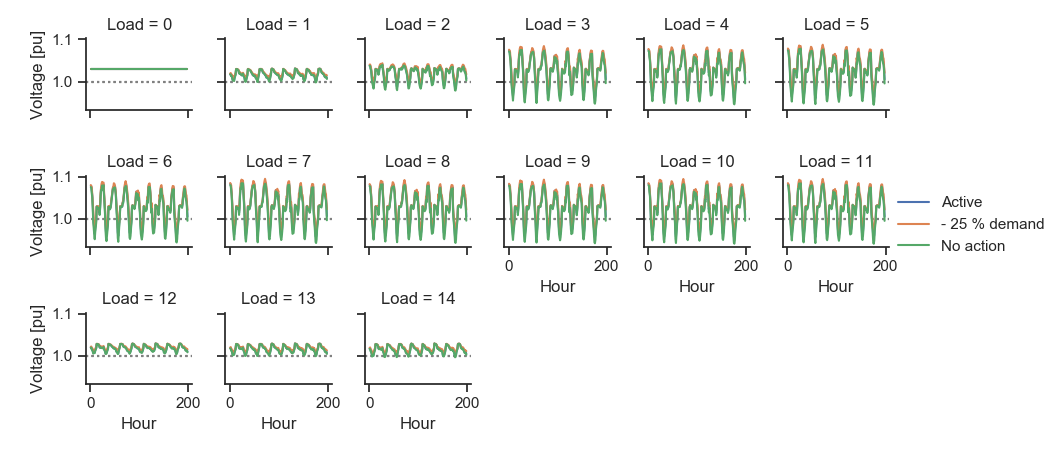

In [176]:
sns.set(style="ticks")
grid = sns.FacetGrid(df, col="Load", hue="",
                     col_wrap=6, height=1.5)


grid.map(plt.axhline, y=1, ls=":", c=".5")

grid.map(plt.plot, "Hour", "Voltage [pu]")
grid.add_legend()



In [177]:
@interact
def plot_voltage(bus_nr=list(range(15))[::-1]):
    data = df[df['Load']== bus_nr]
    fig, ax = plt.subplots()
    sns.lineplot(x="Hour", y="Voltage [pu]", data=data, ax=ax, hue='')
    

interactive(children=(Dropdown(description='bus_nr', options=(14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0…

<IPython.core.display.Javascript object>


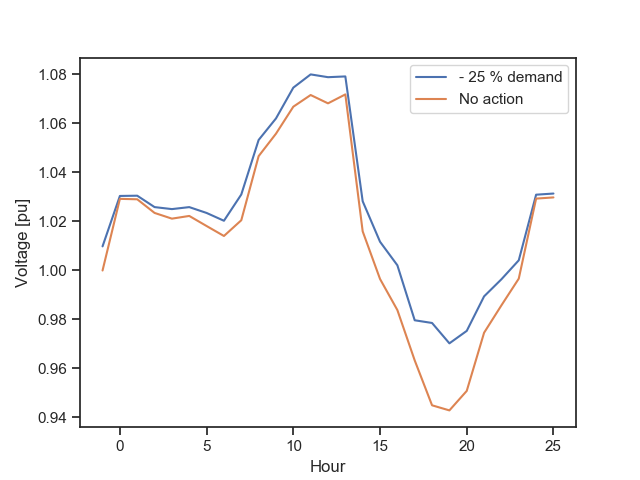

In [178]:
data = df[df['Load']== 8]
data = data[data[''].isin(['No action', '- 25 % demand'])]
data = data[data['Hour'].isin(range(156,183))]
data[''] = data[''].apply(lambda x:change_legend(x))
data['Hour'] = data['Hour'].apply(lambda x:change_hours(x,start=157))
fig, ax = plt.subplots()
sns.lineplot(x="Hour", y="Voltage [pu]", data=data, ax=ax, hue='')

In [180]:
#pickle_savefig(fig,'decrease_demand_voltage')

## Line capacity effect

In [164]:
period=199
#model, env = load_env(seed=9)
env1 = ActiveEnv(seed=9)
net = env1.powergrid
actions = []
t_steps = []
flex_loads = []
obs = env1.reset()
sol = env1.solar_forecasts
hues = []
env1.set_parameters({'flexibility':0.25,
                   'solar_scale':1,
                   'reactive_power':False})
env2 = copy.deepcopy(env1)
env2.set_parameters({'reactive_power':True})
env2.solar_forecasts = env1.solar_forecasts 
env2.demand_forecasts = env1.demand_forecasts
env3 = copy.deepcopy(env1)
env3.do_action = False
legend_map = {0:'Active',1:'+25 % demand', 2: 'No action'}


action = np.ones(18)
#action[[0,10]] = -1

for t_step in range(1,period):

    #action,_ = model.predict(obs)
    action2 = np.ones(18)
    action2[[0,10]] = -1
    
    for i, env in enumerate([env1, env2, env3]):
        obs, rewards, dones, info = env.step(action)
        current = env.powergrid.res_line.loading_percent
        actions += list(current)
        hues += [legend_map[i] for _ in range(len(current))]
        t_steps += list(t_step*np.ones_like(current))
        flex_loads += list(range(len(current)))


df = pd.DataFrame()
df['Line capacity [%]'] = actions
df['Hour'] = t_steps
df['Line'] = flex_loads
df[''] = hues

<IPython.core.display.Javascript object>


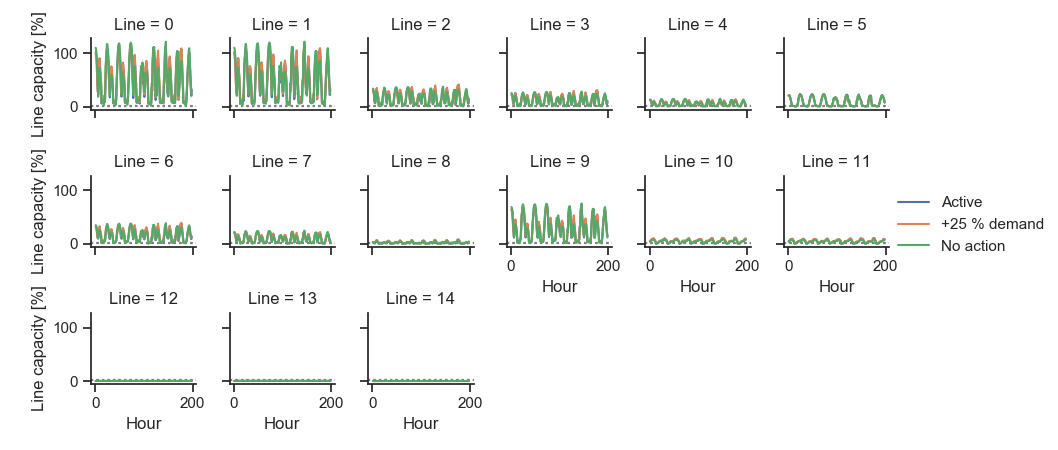

In [165]:
sns.set(style="ticks")
grid = sns.FacetGrid(df, col="Line", hue="",
                     col_wrap=6, height=1.5)


grid.map(plt.axhline, y=1, ls=":", c=".5")

grid.map(plt.plot, "Hour", "Line capacity [%]")
grid.add_legend()



In [166]:
@interact
def plot_current(line_nr=list(range(15))):
    data = df[df['Line']== line_nr]
    fig, ax = plt.subplots()
    sns.lineplot(x="Hour", y="Line capacity [%]", data=data, ax=ax, hue='')
    


interactive(children=(Dropdown(description='line_nr', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

<IPython.core.display.Javascript object>


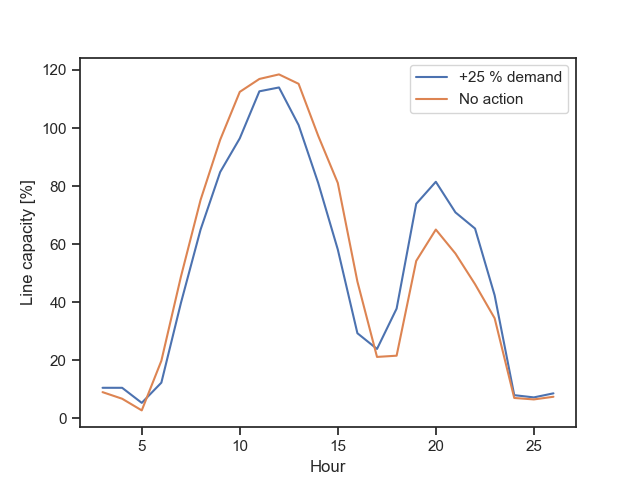

In [167]:
data = df[df['Line']== 0]
data = data[data[''].isin(['No action','+25 % demand'])]
data = data[data['Hour'].isin(range(40,64))]
data['Hour'] = data['Hour'].apply(lambda x:change_hours(x, start=37))
fig, ax = plt.subplots()
sns.lineplot(x="Hour", y="Line capacity [%]", data=data, ax=ax, hue='')
#fig.savefig('figs/increase_demand_current.png')

In [181]:
#pickle_savefig(fig,'increase_demand_current')

## See the difference in reward between agent and no-agent

In [155]:
period=20000
model, env = load_env(seed=9) #seed 5: heavy sun, 9: weak sun
env.set_parameters({'reward_terms': ['current']})
net = env.powergrid
rewards = []
t_steps = []
flex_loads = []
obs = env.reset()
hues = []
env2 = copy.deepcopy(env)
env2.do_action = False
sol = env.solar_forecasts
demand = env.demand_forecasts[0]

show_sun = True
show_demand = True
for t_step in range(1,period):

    action,_ = model.predict(obs)
    obs1, reward1, dones1, info1 = env.step(action)
    obs2, reward2, dones2, info2 = env2.step(action)
    if env._current_step == 0:
        sol = env.solar_forecasts
        demand = env.demand_forecasts[0]
        env2.demand_forecasts = env.demand_forecasts

    
    rewards.append(reward1)
    hues.append('Agent')
    t_steps.append(t_step)
    
    rewards.append(reward2)
    hues.append('No agent')
    t_steps.append(t_step)
    
    if show_sun:    
        rewards.append(sol[env._current_step-1])
        hues.append('Sun')
        t_steps.append(t_step)
        
    if show_demand:
        rewards.append(demand[env._current_step-1])
        hues.append('Demand')
        t_steps.append(t_step)

df = pd.DataFrame()
df['Reward'] = rewards
df['Hours'] = t_steps
df[''] = hues

Loading a model without an environment, this model cannot be trained until it has a valid environment.
setting up target updates ...
  target/pi/fc0/kernel:0 <- model/pi/fc0/kernel:0
  target/pi/fc0/bias:0 <- model/pi/fc0/bias:0
  target/pi/LayerNorm/beta:0 <- model/pi/LayerNorm/beta:0
  target/pi/LayerNorm/gamma:0 <- model/pi/LayerNorm/gamma:0
  target/pi/fc1/kernel:0 <- model/pi/fc1/kernel:0
  target/pi/fc1/bias:0 <- model/pi/fc1/bias:0
  target/pi/LayerNorm_1/beta:0 <- model/pi/LayerNorm_1/beta:0
  target/pi/LayerNorm_1/gamma:0 <- model/pi/LayerNorm_1/gamma:0
  target/pi/pi/kernel:0 <- model/pi/pi/kernel:0
  target/pi/pi/bias:0 <- model/pi/pi/bias:0
  target/qf/fc0/kernel:0 <- model/qf/fc0/kernel:0
  target/qf/fc0/bias:0 <- model/qf/fc0/bias:0
  target/qf/LayerNorm/beta:0 <- model/qf/LayerNorm/beta:0
  target/qf/LayerNorm/gamma:0 <- model/qf/LayerNorm/gamma:0
  target/qf/fc1/kernel:0 <- model/qf/fc1/kernel:0
  target/qf/fc1/bias:0 <- model/qf/fc1/bias:0
  target/qf/LayerNorm_1/beta:

In [156]:
#df.to_csv('data/100_episodes_current.csv',index=False)

<IPython.core.display.Javascript object>


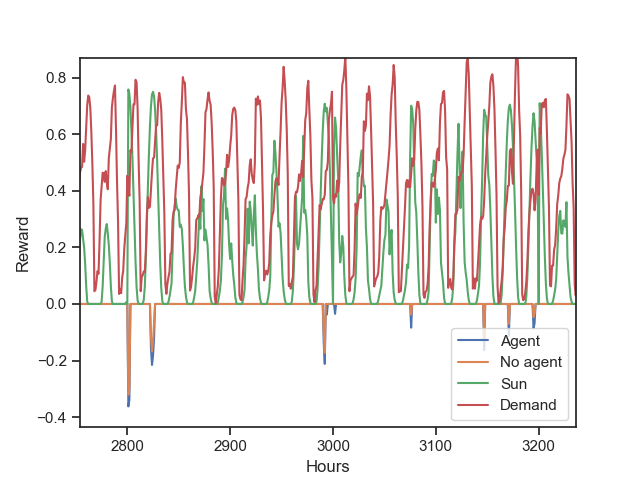

In [157]:
#df = pd.read_csv('data/100_episodes_voltage_reactive.csv')
#df = df.rename(columns={'Unnamed: 2':''})
fig,ax = plt.subplots()
sns.lineplot(x='Hours',y='Reward',data=df,hue='', ax=ax)

In [179]:
rewards = df[df[''].isin(['Agent','No agent'])]
rewards = rewards[rewards['Reward'] < 0]
stats = rewards[['','Reward']].groupby(['']).describe()['Reward']
stats
#stats.iloc[:,:-1].to_csv('data/stats_100episodes_config1_current.csv',float_format='%.3f')

,count,mean,std,min,25%,50%,75%,max
,,,,,,,,
Agent,356.0,-0.184197,0.134569,-0.532398,-0.286467,-0.155767,-0.067354,-0.000006
No agent,329.0,-0.160117,0.126128,-0.496075,-0.261358,-0.129478,-0.052138,-0.000133


In [159]:
cat1 = df[df[''] == 'Agent']['Reward'].values
cat2 = df[df[''] == 'No agent']['Reward'].values
wilcoxon(cat1, cat2)

WilcoxonResult(statistic=5300.0, pvalue=9.75932871931219e-48)

<IPython.core.display.Javascript object>


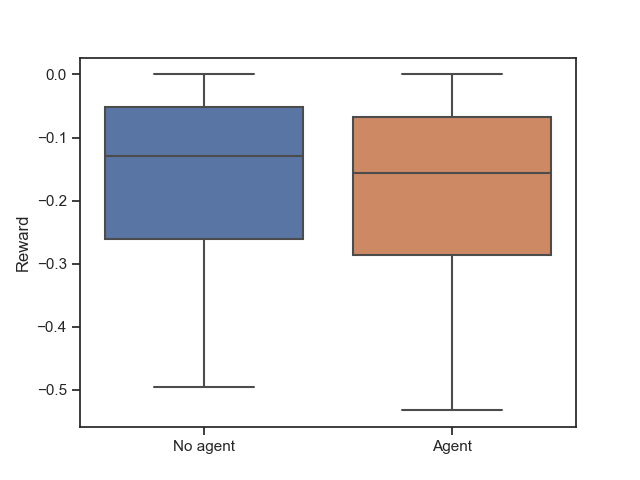

In [160]:
fig, ax = plt.subplots()
sns.boxplot(x="", y="Reward", data=rewards, ax=ax)

## Period the agent is good

<IPython.core.display.Javascript object>


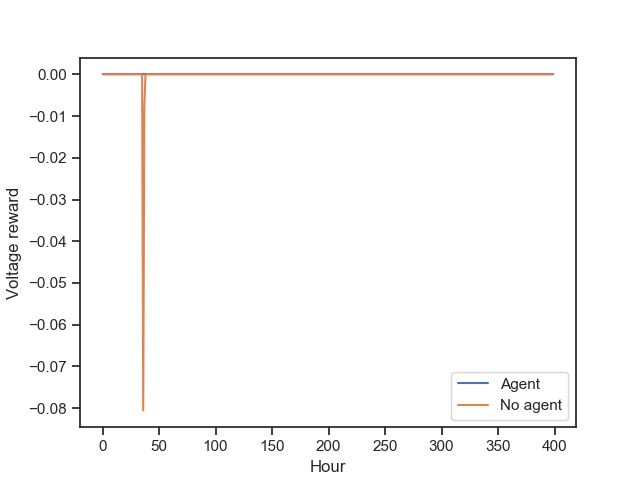

Text(0.5, 0, 'Hour')

In [161]:
rewards = df[df[''].isin(['Agent','No agent'])]
data = rewards
data = data[data['Hours'].isin(range(15600,16000))]
data['Hours'] = data['Hours'].apply(lambda x:change_hours(x, start=15600))
fig, ax = plt.subplots()
sns.lineplot(x="Hours", y="Reward", data=data, ax=ax, hue='')
ax.set_ylabel('Voltage reward')
ax.set_xlabel('Hour')

In [199]:
#pickle_savefig(fig,'config1_400hour_good_voltage')

In [131]:
stats = data[data['Reward'] < 0].groupby('')['Reward'].describe()
stats
#stats.iloc[:,:-1].to_csv('data/config1_400hour_good_voltage.csv',float_format='%.3f')


,count,mean,std,min,25%,50%,75%,max
,,,,,,,,
Agent,26.0,-0.045027,0.052666,-0.186240,-0.079467,-0.023123,-0.003281,-0.000024
No agent,26.0,-0.045033,0.052637,-0.186094,-0.079482,-0.023182,-0.003267,-0.000007


## Periods the agent is bad in terms of voltage
The agent has not learned to cope with high solar power production, period with high solar production have been found manually

<IPython.core.display.Javascript object>


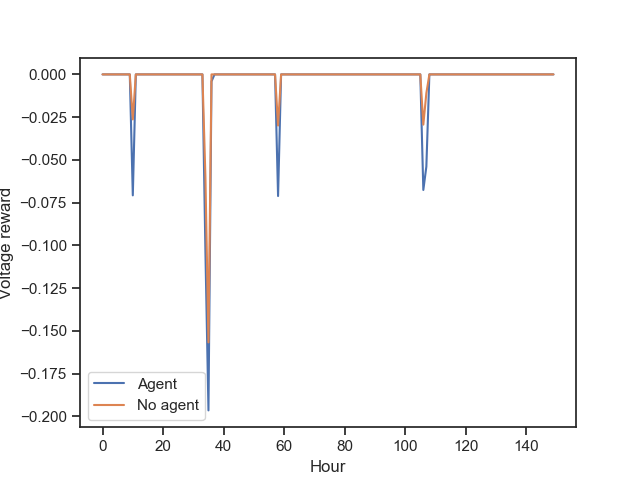

Text(0.5, 0, 'Hour')

In [162]:
rewards = df[df[''].isin(['Agent','No agent'])]
data = rewards
data = data[data['Hours'].isin(range(9800,9950))]
data['Hours'] = data['Hours'].apply(lambda x:change_hours(x, start=9800))
fig, ax = plt.subplots()
sns.lineplot(x="Hours", y="Reward", data=data, ax=ax, hue='')
ax.set_ylabel('Voltage reward')
ax.set_xlabel('Hour')

In [141]:
stats = data[data['Reward'] < 0].groupby('')['Reward'].describe()
stats
#stats.iloc[:,:-1].to_csv('data/config1_150hour_bad_voltage.csv',float_format='%.3f')

,count,mean,std,min,25%,50%,75%,max
,,,,,,,,
Agent,22.0,-0.027510,0.027736,-0.094126,-0.035549,-0.021175,-0.002520,-0.000959
No agent,22.0,-0.027346,0.027668,-0.093878,-0.035297,-0.021104,-0.002455,-0.000901


## Distribution in critical hours

In [163]:

agent = df[df[''] == 'Agent']

normal = df[df[''] == 'No agent']
bad_normal = normal[normal['Reward'] < 0]
bad_hours = bad_normal['Hours']
bad_agent = agent[agent['Hours'].isin(bad_hours.values)]
bad_agent['No agent'] = bad_normal['Reward'].values
bad_agent['normal_hours'] = bad_hours.values
bad_agent = bad_agent.rename(columns={'Reward':'Agent'})
assert all(bad_agent['normal_hours'] == bad_agent['Hours'])

<IPython.core.display.Javascript object>


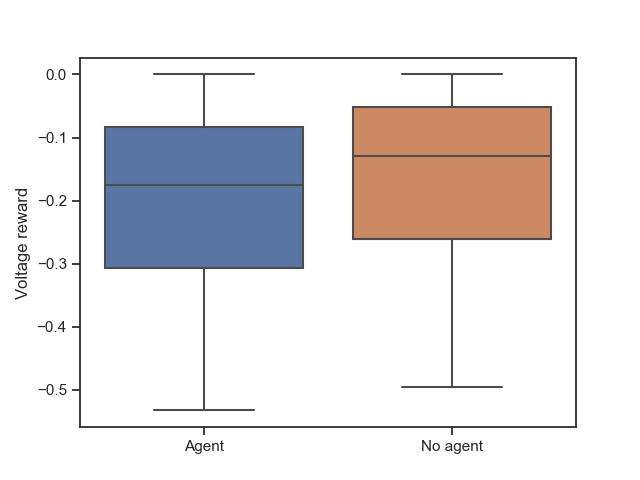

Text(0, 0.5, 'Voltage reward')

In [164]:
stacked = stack_columns(bad_agent,['Agent', 'No agent'])
fig, ax = plt.subplots()
sns.boxplot(x='', y="Reward", data=stacked, ax=ax)
ax.set_ylabel('Voltage reward')

In [235]:
#pickle_savefig(fig, 'config1_voltage_violin')

In [165]:
stats = stacked.groupby('')['Reward'].describe()
stats
#stats.iloc[:,:-1].to_csv('data/config1_1000ep_critical.csv',float_format='%.3f')


,count,mean,std,min,25%,50%,75%,max
,,,,,,,,
Agent,329.0,-0.195314,0.134282,-0.532398,-0.307299,-0.175316,-0.083759,-0.000000
No agent,329.0,-0.160117,0.126128,-0.496075,-0.261358,-0.129478,-0.052138,-0.000133


## T-test to see find difference

In [166]:
cat1 = bad_agent['Agent']
cat2 = bad_agent['No agent']
wilcoxon(cat1, cat2)

WilcoxonResult(statistic=4364.0, pvalue=9.668243859934213e-40)

In [ ]:
1.420434633956915e-97

## Sort rewards of the agent

<IPython.core.display.Javascript object>


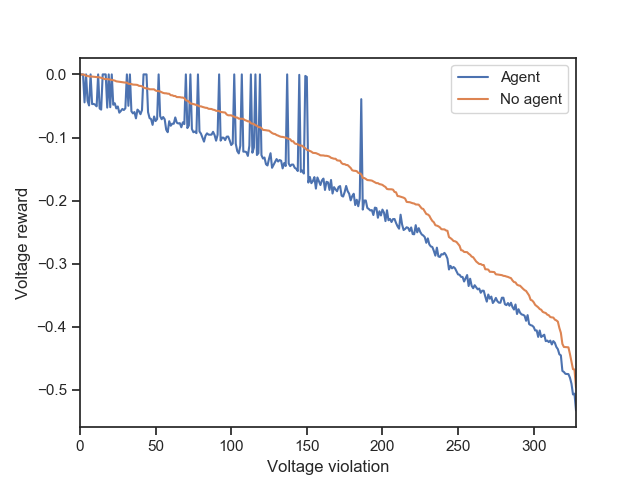

Text(0, 0.5, 'Voltage reward')

In [167]:
fig, ax = plt.subplots()
sorted_agent = bad_agent.sort_values(by='No agent',ascending=False)
sorted_agent = sorted_agent.reset_index()
sorted_agent.plot(y=['Agent','No agent'],ax=ax)
ax.set_xlabel('Voltage violation')
ax.set_ylabel('Voltage reward')

In [273]:
#pickle_savefig(fig,'config1_sorted_voltage')

In [168]:
data = sorted_agent[['Agent','No agent']]
data[data['Agent'] > data['No agent']].describe()

,Agent,No agent
count,31.000000,31.000000
mean,-0.001497,-0.043525
std,0.007055,0.044176
min,-0.039246,-0.158381
25%,-0.000000,-0.073866
50%,-0.000000,-0.022319
75%,-0.000000,-0.007331
max,-0.000000,-0.000133


In [169]:
(data['Agent'] > data['No agent']).mean()

0.09422492401215805

<IPython.core.display.Javascript object>


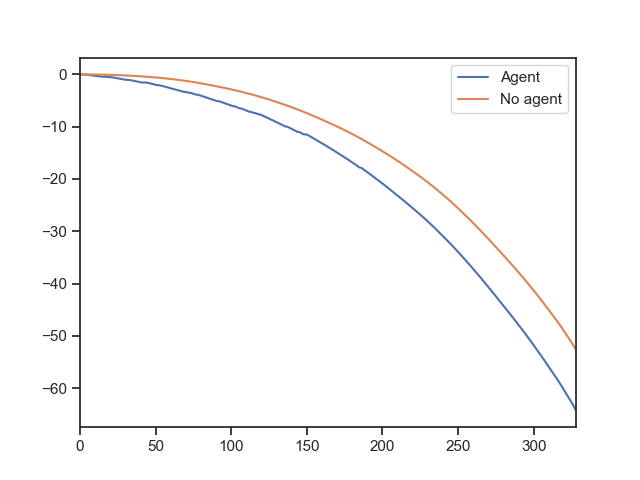

In [170]:
data.cumsum().plot()

## Trained agent in non-critical periods

<IPython.core.display.Javascript object>


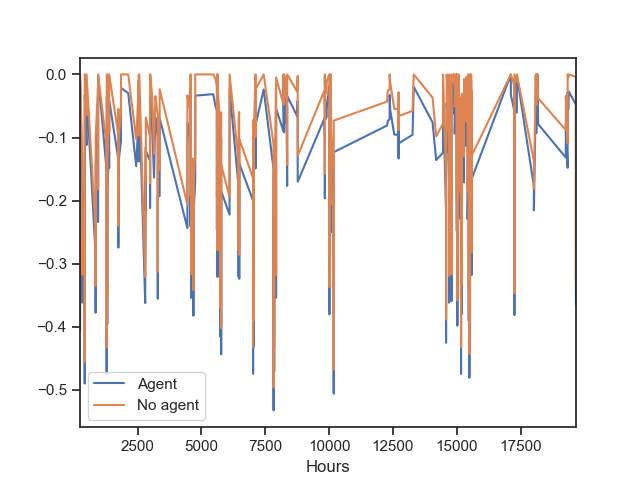

In [171]:
agent = df[df[''] == 'Agent']

normal = df[df[''] == 'No agent']
data = agent[['Hours']].reset_index(drop=True)
data['Agent'] = agent['Reward'].values
data['No agent'] = normal['Reward'].values
assert all(data['Hours'].values == normal['Hours'].values)

worse = data[data['Agent'] < data['No agent']]
worse.plot(x='Hours')

## Non critical hours when the normal operation give no penalty
Most of the time the safety margins are not violated. How is the trained agent behaving in these hours?

In [172]:

agent = df[df[''] == 'Agent']

normal = df[df[''] == 'No agent']
bad_normal = normal[normal['Reward'] == 0]
bad_hours = bad_normal['Hours']
bad_agent = agent[agent['Hours'].isin(bad_hours.values)]
bad_agent['No agent'] = bad_normal['Reward'].values
bad_agent['normal_hours'] = bad_hours.values
bad_agent = bad_agent.rename(columns={'Reward':'Agent'})
assert all(bad_agent['normal_hours'] == bad_agent['Hours'])
#bad_agent = bad_agent[['Agent','No agent']]

In [173]:
bad_agent.loc[bad_agent['Agent'].idxmin(),:]

Agent          -0.0461506
Hours               15447
                    Agent
No agent               -0
normal_hours        15447
Name: 61784, dtype: object

In [174]:
(bad_agent['Agent'] < 0).mean()

0.0027452974072191155

<IPython.core.display.Javascript object>


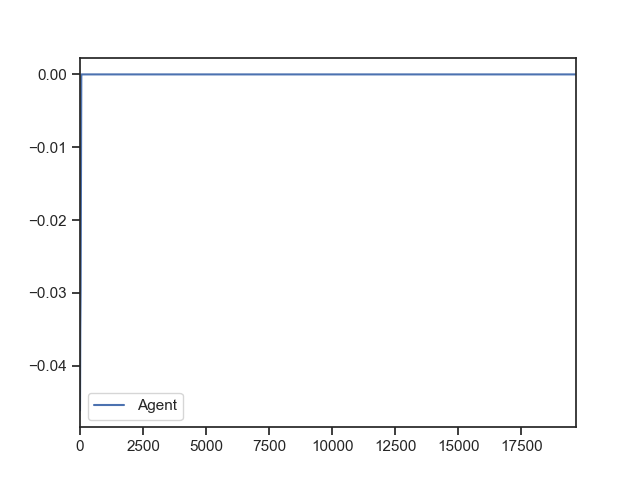

In [175]:
bad_agent[['Agent','No agent']].sort_values(by='Agent').reset_index().plot(y='Agent')

In [176]:
bad_agent[bad_agent['Agent'] < 0].describe()

,Agent,Hours,No agent,normal_hours
count,54.000000,54.000000,54.0,54.000000
mean,-0.024364,10144.148148,0.0,10144.148148
std,0.013841,6268.411714,0.0,6268.411714
min,-0.046151,252.000000,-0.0,252.000000
25%,-0.034655,4623.000000,-0.0,4623.000000
50%,-0.027858,10061.500000,-0.0,10061.500000
75%,-0.011641,15037.250000,-0.0,15037.250000
max,-0.000006,19388.000000,-0.0,19388.000000


In [65]:
bad_agent.mean()

Agent             -0.000003
Hours           9987.788776
No agent           0.000000
normal_hours    9987.788776
dtype: float64